# Problem - Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

# Load Data

The data is loaded using Kaggle's API.

In [1]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3054           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11440            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4817            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         38           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3217           False  
recognizing-faces-in-the-wild                      2019-08-01 23:59:00  Playground       Knowledge      

O sistema nÆo pode encontrar o caminho especificado.


In [2]:
!kaggle competitions files -c humpback-whale-identification

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv  498KB  2018-11-30 17:56:30  
train.csv              594KB  2018-11-30 17:56:34  
test.zip                 1GB  2018-11-30 17:57:09  
train.zip                4GB  2018-11-30 17:59:21  


O sistema nÆo pode encontrar o caminho especificado.


In [7]:
!kaggle competitions download -c humpback-whale-identification

401 - Unauthorized


# Organizing the Dataset

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models
from PIL import Image
from itertools import combinations, chain
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader, random_split

# Create Dataset for Triplet Loss with Anchor/Positive/Negative

In [2]:
def creat_dataset(csv_file, min_imgs, save_result=True, save_name='APN.csv'):
    """
    Creates the dataframe with the names of the images in the anchor/positive/negative format.
        Args:
            csv_file (string): Path to csv with the images/labels.
            min_imgs (int): Minimal number of images of one kind to include on the data.
        Retun:
            df: DataFrame object
    """
    # Prepare DataFrame with the pair of images
    whales_frame = pd.read_csv(csv_file)
    
    # Series with list of images for each ID
    whales_id = whales_frame.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")
    whales_id['Counts'] = whales_id.Image.str.count('.jpg') # total images
    whales_id = whales_id.sort_values('Counts', ascending=False) # sorted
    whales_id = whales_id[whales_id.Counts >= min_imgs] # filter
    
    # Series with list of images for each ID
    apn_dict = dict(Anchor=[], Positive=[], Negative=[])
    image_pool = whales_frame.Image

    # Calculates combinations of positive matches
    for idx, v in tqdm_notebook(whales_id.Image.iteritems()):
        imgs = v.split(",")
        sub_pool = image_pool[~image_pool.isin(imgs)]
        combined = combinations(imgs, 2)
        # For each valid pair
        for c in combined:
            apn_dict['Anchor'].append(c[0])
            apn_dict['Positive'].append(c[1])
            apn_dict['Negative'].append(np.random.choice(sub_pool))

    # Creates dataframe
    df = pd.DataFrame(apn_dict)
    
    # Save result
    if save_result:
        df.to_csv(save_name)

    return df

In [3]:
# Create initial df
csv_file = 'humpback-whale-identification\\train.csv'

data_df = creat_dataset(csv_file, min_imgs=4)

In [4]:
class WhaleDataset(Dataset):
    """
    Creates the dataset ready to apply triplet loss.
    """
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe: Data frame with the APN images.
            root_dir: Root directory of the images.
            transform: Tranformation applied to the images.
        
        Return:
            Dataset
        """ 
        # Attributes
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        if type(idx) == torch.Tensor:
            idx = idx.item()
        # Load images
        anchor_img_path = os.path.join(self.root_dir,
                                       self.data.iloc[idx, 0])
        pos_img_path = os.path.join(self.root_dir,
                                    self.data.iloc[idx, 1])
        neg_img_path = os.path.join(self.root_dir,
                                    self.data.iloc[idx, 2])
        anchor_img = Image.open(anchor_img_path).convert('RGB')
        pos_img = Image.open(pos_img_path).convert('RGB')
        neg_img = Image.open(neg_img_path).convert('RGB')
        
        # Data augmentation
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        # Output
        sample = (anchor_img, pos_img, neg_img)
        
        return sample
    

In [6]:
csv_file = 'humpback-whale-identification\\train.csv'
root_dir = 'humpback-whale-identification\\train'
# OBS.: No Data augmentation
transform = T.Compose([T.Resize((255, 255)),
                       T.CenterCrop(224),
                       T.ToTensor()
                      ])
# T.Normalize(mean=[0.485, 0.456, 0.406],
#                                    std=[0.229, 0.224, 0.225])
# Dataset
whale_dataset = WhaleDataset(data_df, root_dir, transform=transform)

In [7]:
# Train Test Split
train_size = int(0.8 * len(whale_dataset))
test_size = len(whale_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(whale_dataset, [train_size, test_size])

torch.Size([3, 224, 224])


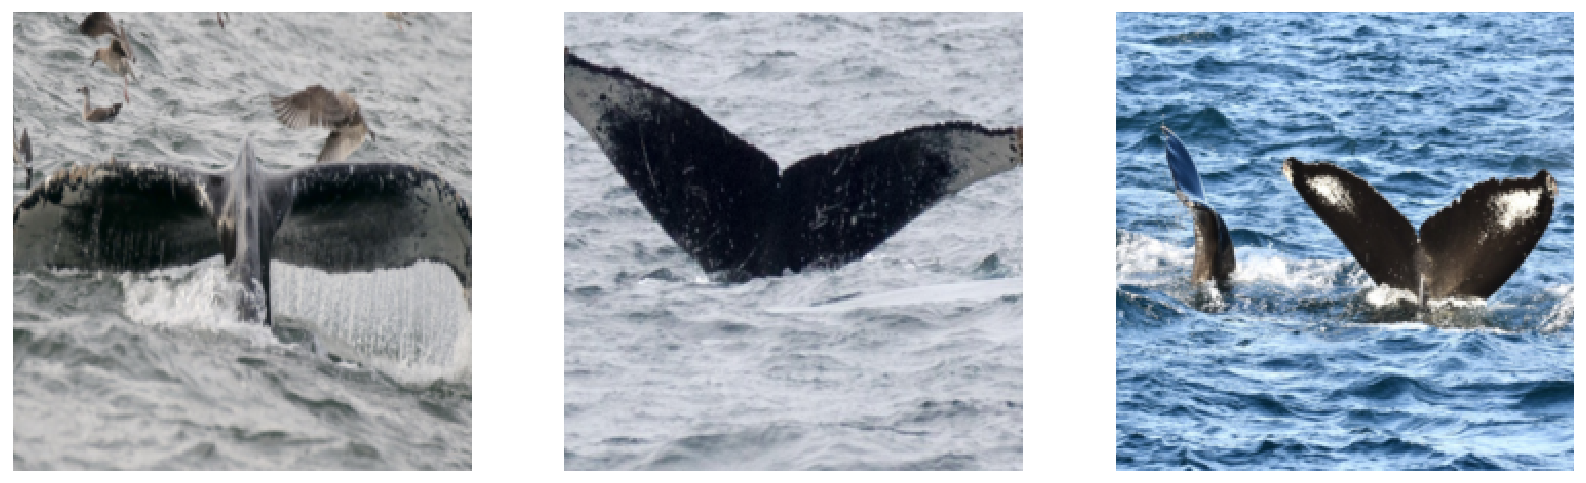

In [53]:
# Load data
iter_data = iter(whale_dataset)
next(iter_data)
next(iter_data)
next(iter_data)
next(iter_data)
next(iter_data)
next(iter_data)
next(iter_data)
img1, img2, img3 = next(iter_data)

# Check the size of the images
print(img1.size())

# Check the images
imgs_1 = img1.numpy()
imgs_2 = img2.numpy()
imgs_3 = img3.numpy()

# Plot images
f = plt.figure(figsize=(28, 10))
ax1 = f.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax2 = f.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax3 = f.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax1.imshow(np.transpose(imgs_1, (1, 2, 0)))
ax2.imshow(np.transpose(imgs_2, (1, 2, 0)))
ax3.imshow(np.transpose(imgs_3, (1, 2, 0)))


#### Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Building and Training a Model

Model from the ground

The model will consist of a feture extrator for the whale pictures.

In [9]:
import torch
from torch import nn
from torch import optim
import torch.functional as F
from tqdm import tqdm

In [10]:
# Model
class WhaleSimilarity(nn.Module):
    """
    Network defining class.
    
    Args:
        features_net: Network to get the features from the images. 
                      Should contain the attribute `num_features`.
    """
    def __init__(self, features_net=None):
        super(WhaleSimilarity, self).__init__()
        # Sequence of Convolution + Maxpool Layers
        self.features = nn.Sequential(nn.Conv2d(3, 8, 3, padding=1),  # sees 224x224x3 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(8, 16, 3, padding=1),  # sees 112x112x8 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(16, 32, 3, padding=1),  # sees 56x56x16 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(32, 64, 3, padding=1),  # sees 28x28x32 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(64, 128, 3, padding=1),  # sees 14x14x64 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(128, 16, 1),  # sees 7x7x128 tensor
                                      nn.ReLU()  # outputs 7x7x16 tensor
                                     )
        self.num_features = 16 * 7 * 7

    def forward(self, x):
        """
        Forward pass in the network.
        """
        # Sequence of Conv2D + Maxpool
        x = self.features(x)
        # Flatten result
        x = x.view(-1, self.num_features)
        
        return x


In [11]:
# check if CUDA is available
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if train_device == 'cpu':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [12]:
# Defines Model
model = WhaleSimilarity()
model.to(train_device)

WhaleSimilarity(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (16): ReLU()
 

In [13]:
# PARAMETERS
LR = 0.006
MARGIN = .5
LR_SCHEDULER_FACTOR = .5
BATCH_SIZE = 192

In [14]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.TripletMarginLoss(margin=MARGIN)

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 factor=LR_SCHEDULER_FACTOR,
                                                 patience=3)
# Dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [15]:
# Auxiliary functions
def save_checkpoint(model, optimizer, scheduler, epoch, losses, file_name):
    """
    Saves the current model checkpoint
    
    Args:
        model: Model used.
        optimizer: Optimizer used.
        Scheduler: Scheduler used.
        epoch: Epouch number.
        losses: Dict with the losses.
        file_name: name of the saved file.
        
    """
    # Saves the model
    checkpoint = {"model_state_dict": model.state_dict(),
                  "optim_state_dict": optimizer.state_dict(),
                  "scheduler_state_dict": scheduler.state_dict(),
                  "epoch": epoch,
                  "train_loss": losses["train"],
                  "valid_loss": losses["valid"]}
    torch.save(checkpoint, file_name)
    
def load_checkpoint(model, optimizer, scheduler, losses, file_name, location='cuda'):
    """
    Load all info from last model.
    
    Args:
        model: Initialized Model.
        optimizer: Initialized Optimizer.
        Scheduler: Initialized Scheduler.
        losses: Initialized Dict with the losses.
        file_name: name of the saved file.
        location: Where to load the model.
    """
    # Loads the model
    checkpoint = torch.load(file_name, map_location=location)
    
    # Load in given objects
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optim_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    losses["train"] = checkpoint["train_loss"]
    losses["valid"] = checkpoint["valid_loss"]

In [16]:
# save_checkpoint(model, optimizer, scheduler, 1, losses, 'whale_model_last.pth')
# load_checkpoint(model, optimizer, scheduler, losses, 'whale_model_last.pth')

In [18]:
def train(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs=3,
          init_val_loss=np.Inf, print_every=50, train_device='cuda'):
    """
    Function to train the model
    
    Args:
        model: Model used.
        optimizer: Optimizer used.
        criterion: Criterion used
        train_dataloader: Dataloader used
        test_dataloader: Dataloader used
        n_epochs: Max number of epochs.
        init_val_loss: Initial validation loss.
        print_very: print this number of batches.
        train_device: device used for training.
    """
    # Losses array
    losses = {"train":[], "valid":[]}
    # Progress bar
    pbar_epochs = tqdm_notebook(range(1, n_epochs + 1), total=n_epochs, ncols=100)
    for epoch in pbar_epochs:
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss_min = init_val_loss

        ###################
        # train the model #
        ###################
        model.train()
        total_train = len(train_dataloader.dataset)
        pbar_train = tqdm_notebook(enumerate(train_dataloader, 1), total=total_train//BATCH_SIZE, ncols=50)
        for c, (a, p, n) in pbar_train:
            # Move tensors to GPU, if CUDA is available
            a, p, n = a.to(train_device), p.to(train_device), n.to(train_device)
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Batch size
            bs = a.size(0)
            # forward pass
            a_feats = model(a)
            p_feats = model(p)
            n_feats = model(n)
            # calculate the batch loss
            #import ipdb; ipdb.set_trace() # debugging starts here
            loss = criterion(a_feats, p_feats, n_feats)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() * bs
            # show partial results
            if c % print_every == 0:
                # print training statistics 
                pbar_train.set_description('Batch: {:5d}/{:5d} Training Loss: {:2.6f}'.format(
                c,
                len(train_dataloader),
                train_loss / (bs * c)
                ))
        
        # Validate model
        valid_loss = validate_model(model, criterion, test_dataloader, train_device)
        losses["valid"].append(valid_loss)
        # calculate average losses
        train_loss = train_loss / total_train
        losses["train"].append(train_loss)
        # Save the model if validation loss has decreased
        save_model = False
        if valid_loss < valid_loss_min:
            # update the min_loss
            valid_loss_min = valid_loss
            # Saves the model
            save_checkpoint(model, optimizer, scheduler, epoch, losses, "Model_" + str(epoch))
            save_model = True

        # print training/validation statistics 
        output_str = 'Epoch: {:3d}/{:3d} Training Loss: {:2.6f} Validation Loss: {:2.6f} Saving Model: {}'
        pbar_epochs.set_description(output_str.format(epoch, n_epochs, train_loss, valid_loss, save_model))

        # Scheduler step
        scheduler.step(valid_loss)
    
    # Return losses
    return losses
    

def validate_model(model, criterion, data_loader, train_device='cuda'):
    """
    Validathede given model on dataloader
    
    Args:
        model: Model used.
        criterion: Criterion used
        data_loader: Dataloader used
        train_device: device used for validation.
    """
    ######################    
    # validate the model #
    ######################
    # Initializa valid loss
    valid_loss = 0.0
    # Move to device
    model = model.to(train_device)
    total_valid = len(data_loader.dataset)
    # Evalutions mode
    model.eval()
    with torch.no_grad():
        for a, p, n in tqdm_notebook(data_loader, total=total_valid//BATCH_SIZE, ncols=50):
            # move tensors to GPU if CUDA is available
            a, p, n = a.to(train_device), p.to(train_device), n.to(train_device)
            bs = a.size(0)
            
            # Check cache
            a_feats = model(a)
            p_feats = model(p)
            n_feats = model(n)
            
            # calculate the batch loss
            loss = criterion(a_feats, p_feats, n_feats)
            
            # update average validation loss 
            valid_loss += loss.item() * bs
    # Valid loss
    valid_loss = valid_loss / total_valid

    return valid_loss

In [19]:
# Train model
losses = train(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs=20, print_every=50)

{'train': [0.3631167256966561,
  0.27612829919906,
  0.2234559273058948,
  0.19611095412917373,
  0.17653468194359193,
  0.16297084977292128,
  0.15152551083860968,
  0.1431016322695393,
  0.13917662929311583,
  0.13157845729696077,
  0.1303550638693879,
  0.1249409668199592,
  0.12136861717495294,
  0.12087832465770643,
  0.11639668343347975,
  0.1166571180405977,
  0.11176212144024213,
  0.11005064950448858,
  0.10953721895086663,
  0.10649392269561492],
 'valid': [0.31479868880842404,
  0.2420208713427865,
  0.21832196605882154,
  0.1838847438442431,
  0.17978265216717354,
  0.1617043433503663,
  0.1605638104579269,
  0.15295593899475096,
  0.15363166205156553,
  0.14725057013761295,
  0.14017524199756426,
  0.1424827724528277,
  0.1350680462431783,
  0.15902661394280582,
  0.12950074256045147,
  0.13616165808771333,
  0.12980694982367189,
  0.1238788090685217,
  0.12748086420433835,
  0.1302858758186386]}

In [29]:
img_info = pd.read_csv("humpback-whale-identification/train.csv")
# Series with list of images for each ID
whales_id = img_info.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")
whales_id['Counts'] = whales_id.Image.str.count('.jpg') # total images
whales_id = whales_id.sort_values('Counts', ascending=False) # sorted
whales_id = whales_id[whales_id.Counts >= 4] # filter
whales_id.to_csv("Whales_IDs")

In [35]:
csv_file = 'humpback-whale-identification\\train.csv'
root_dir = 'humpback-whale-identification\\train'
# OBS.: No Data augmentation
transform = T.Compose([T.Resize((255, 255)),
                       T.CenterCrop(224),
                       T.ToTensor()
                      ])

In [31]:
for 
images_paths = os.path.join(root_dir,
                            data.iloc[idx, 0])
img = transform(img)
batch = 

,Image,Counts
Id,,
w_23a388d,"02bdec750.jpg,02f250971.jpg,03b6593e9.jpg,043b...",73
w_9b5109b,"047f23339.jpg,076719457.jpg,07733181b.jpg,0812...",65
w_9c506f6,"00570db6b.jpg,13a7495d5.jpg,15685f504.jpg,158c...",62


In [38]:
whales_id.head()

,Image,Counts
Id,,
w_23a388d,"02bdec750.jpg,02f250971.jpg,03b6593e9.jpg,043b...",73
w_9b5109b,"047f23339.jpg,076719457.jpg,07733181b.jpg,0812...",65
w_9c506f6,"00570db6b.jpg,13a7495d5.jpg,15685f504.jpg,158c...",62
w_0369a5c,"00e9e5122.jpg,06ae83bbc.jpg,092ef02b8.jpg,1267...",61
w_700ebb4,"00910010d.jpg,0962efdb7.jpg,0c057c0a6.jpg,125b...",57


In [ ]:
def eval_model(model, model_input, device="cpu"):
    """
    Evaluates the model safely.
    
    Args:
        model: Model evaluated.
        model_input: Input to the model
        device: Device to run the model
    
    Return:
        output: Model output
    """
    model.eval()
    with torch.no_grad():
        # Move tensors and model to device
        model_input = model_input.to(device)
        model = model.to(device)
        
        # Propagate
        output = model(model_input)
    
    return output

In [50]:
torch.tensor([i for i in range(3)])

tensor([0, 1, 2])

In [36]:
def cache_features(model, csv_file, root_dir, transform,device="cuda"):
    """
    Cache features for each ID.
    
    Args:
        model: Model used.
        csv_file: Path to csv with images info.
        root_dir: Root directory of images.
        transform: Transformations applied.
        device: Device used for propagation.
    """
    # Load csv
    img_info = pd.read_csv(csv_file)
    
    # Images for each ID
    whales_id = img_info.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")
    whales_id['Counts'] = whales_id.Image.str.count('.jpg') # total images
    whales_id = whales_id.sort_values('Counts', ascending=False) # sorted
    
    # Preprare batch
    pbar = tqdm_notebook(whales_id.Image.items())
    for idx, images in pbar:
        imgs = images.split(",")
        # List of paths
        imgs = [os.path.join(root_dir, img) for img in imgs]
        # Creates a batch for each id
        batch = torch.tensor()
        
    
    
    

In [37]:
# Create temp ds
create_id_datasets(csv_file, 4)

In [ ]:
class WhaleDataset(Dataset):
    """
    Creates the dataset ready to apply triplet loss.
    """
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe: Data frame with the APN images.
            root_dir: Root directory of the images.
            transform: Tranformation applied to the images.
        
        Return:
            Dataset
        """ 
        # Attributes
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        if type(idx) == torch.Tensor:
            idx = idx.item()
        # Load images
        anchor_img_path = os.path.join(self.root_dir,
                                       self.data.iloc[idx, 0])
        pos_img_path = os.path.join(self.root_dir,
                                    self.data.iloc[idx, 1])
        neg_img_path = os.path.join(self.root_dir,
                                    self.data.iloc[idx, 2])
        anchor_img = Image.open(anchor_img_path).convert('RGB')
        pos_img = Image.open(pos_img_path).convert('RGB')
        neg_img = Image.open(neg_img_path).convert('RGB')
        
        # Data augmentation
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        # Output
        sample = (anchor_img, pos_img, neg_img)
        
        return sample

# Model Metrics
Currently, using AUC ROC Curve as the main metric.

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(score, fpr, tpr):
    """
    Plot ROC curve of the model in th evlidation data
    
    score: ROC score (AUC)
    fpr: False positive rate.
    tpr: true positive rate.
    """
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (Score = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# score, fpr, tpr = validate_model(model, criterion, whale_dataset, data_loader, train_device='cuda')

In [16]:
# plot_roc(score, fpr, tpr)

# Transfer Learning

Using transfer learning as features extractors.

In [19]:
# Load Pretrained Models
resnet50 = models.resnet50(pretrained=True)
# resnet152 = models.resnet152(pretrained=True)

# alexnet = models.alexnet(pretrained=True)

# squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
# vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
# densenet161 = models.densenet161(pretrained=True)

# inception3 = models.inception_v3(pretrained=True)

c:\program files\python36\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [61]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [20]:
# Add attributes to models
resnet50.num_feats = 2048
vgg16.num_feats= 25088
densenet121.num_feats = 50176

# TODO Change 1024 to 1024 * 7 * 7
transfer_model = densenet121
transfer_model = transfer_model.to(train_device)

In [21]:
model = WhaleSimilarity(transfer_model)
model = model.cuda()

In [22]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Losses array
losses = {"train":[], "valid":[]}

In [23]:
train(model, optimizer, criterion, whale_dataset, data_loader, n_epochs=1)

  0%|                                                                                        | 0/15995 [00:00<?, ?it/s]c:\program files\python36\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
  4%|███▏                                                                        | 666/15995 [08:04<3:18:48,  1.29it/s]c:\program files\python36\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
  4%|███▏                                                                        | 667/15995 [08:05<2:44:13,  1.56it/s]


UnboundLocalError: local variable 'valid_loss_min' referenced before assignment